In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns




os.listdir('/kaggle/input')

2025-10-20 16:46:57.509267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760978817.740276      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760978817.804705      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['chest-xray-pneumonia']

## Data Visualization

In [2]:
os.listdir('/kaggle/input/chest-xray-pneumonia')


['chest_xray']

In [3]:
os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray')

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [4]:


base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"

train_dir = f"{base_dir}/train"
val_dir   = f"{base_dir}/val"
test_dir  = f"{base_dir}/test"

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)


Found 5216 files belonging to 2 classes.


I0000 00:00:1760978837.223550      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760978837.224217      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


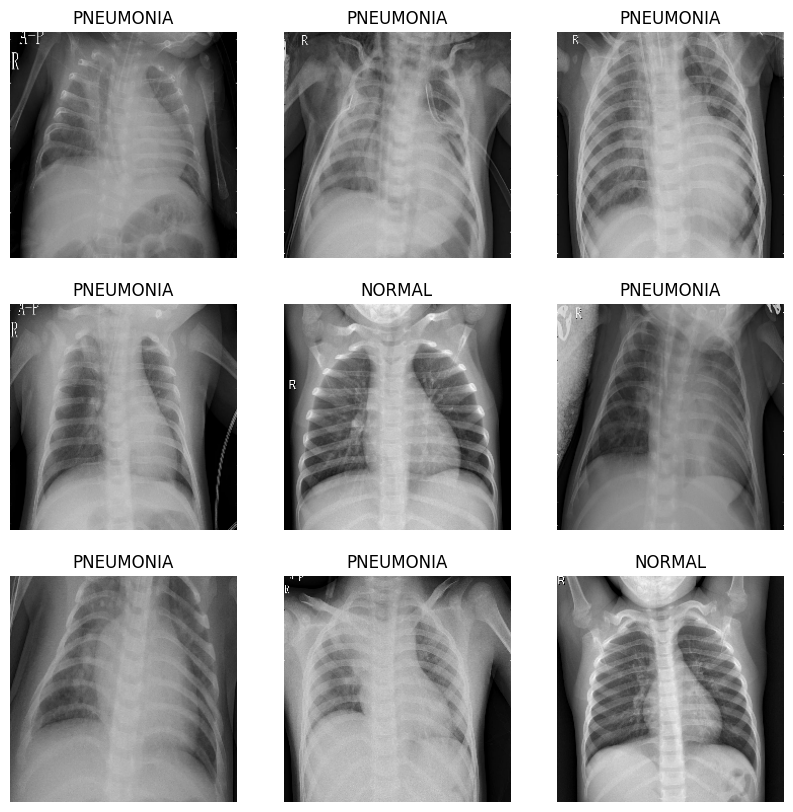

In [5]:

class_names = train_ds.class_names  # ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): #take first barch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


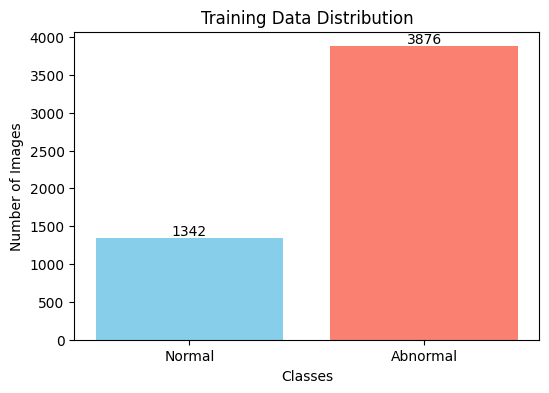

In [6]:

# Count images in each class
normal_count = len(os.listdir(f"{train_dir}/NORMAL"))
abnormal_count = len(os.listdir(f"{train_dir}/PNEUMONIA"))

# Bar chart
labels = ['Normal', 'Abnormal']
counts = [normal_count, abnormal_count]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.title("Training Data Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")

# 🪄 This single line adds the numbers on top of bars
plt.bar_label(bars)

plt.show()


In [7]:
print(counts,labels)

[1342, 3876] ['Normal', 'Abnormal']


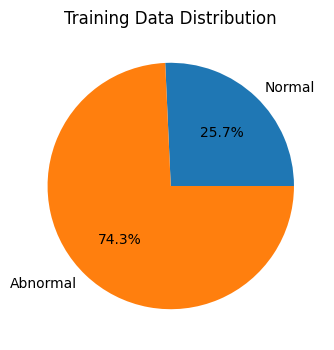

In [8]:
plt.figure(figsize=(6,4))
pie = plt.pie(counts,labels=labels,autopct='%1.1f%%')
plt.title("Training Data Distribution")
plt.show()

## CNN

### making augmentation

In [9]:
# This creates a mini model that randomly transforms images on the fly during training — without actually saving new images
data_augmentation = tf.keras.Sequential([ #####
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    
])

In [27]:
cnn_model=tf.keras.Sequential([
    data_augmentation ,#####
    tf.keras.layers.Conv2D(filters =16,kernel_size=(3,3),input_shape=(224,224,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [28]:
cnn_model.compile(#optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
                  optimizer='adam'
                  ,loss='binary_crossentropy',
                  metrics=['accuracy'])

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [32]:
cnn_history=cnn_model.fit(train_ds,epochs=15, validation_data=val_ds,batch_size=32,callbacks=[early_stop])

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7378 - loss: 0.5841 - val_accuracy: 0.5000 - val_loss: 0.8350
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7356 - loss: 0.5862 - val_accuracy: 0.5000 - val_loss: 0.8353
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.7368 - loss: 0.5847 - val_accuracy: 0.5000 - val_loss: 0.8354
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.7356 - loss: 0.5857 - val_accuracy: 0.5000 - val_loss: 0.8356


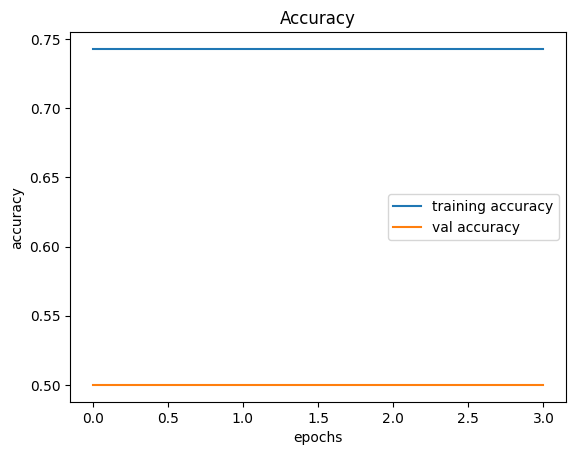

In [33]:
plt.figure(0)
plt.plot(cnn_history.history['accuracy'], label='training accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

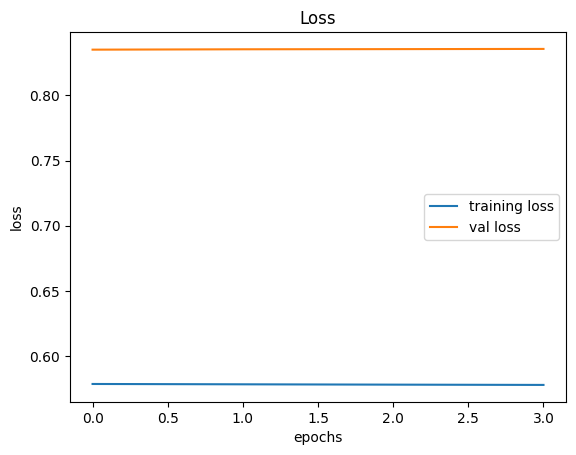

In [34]:
plt.plot(cnn_history.history['loss'], label='training loss')
plt.plot(cnn_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [35]:
cnn_model.save('cnn_model_chestXray.h5')